In [9]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#implement linear regression
from sklearn.linear_model import LinearRegression

#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [10]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [11]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [20]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

dataset_train = dataset_train[['close', 'compound']]
dataset_train = dataset_train.dropna()
dataset_train = dataset_train.astype('float')

<ipython-input-11-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


In [21]:
dataset_train.count()

close       309
compound    309
dtype: int64

In [43]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Compound'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Compound'][i] = comp_df['compound'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values.astype('float')

train = dataset[0:270,:]
valid = dataset[270:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1, activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/10
210/210 - 5s - loss: 0.1845 - accuracy: 0.0048
Epoch 2/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 3/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 4/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 5/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 6/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 7/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 8/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 9/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
Epoch 10/10
210/210 - 2s - loss: 0.1845 - accuracy: 0.0048
[0.18445919454097748, 0.18445929884910583, 0.18445926904678345, 0.18445919454097748, 0.18445923924446106, 0.18445919454097748, 0.18445923924446106, 0.18445926904678345, 0.18445923924446106, 0.18445917963981628]
[0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.004761904943734407, 0.0047619

In [40]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [41]:
valid = np.nan_to_num(valid)
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

561.876273600771

<ipython-input-42-0f12abd7e99c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


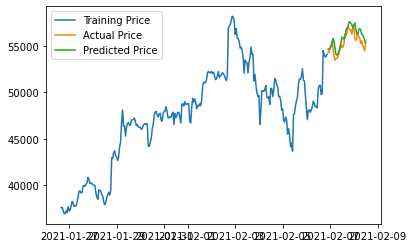

In [42]:
#for plotting
train = new_data[:270]
valid = new_data[270:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

In [34]:
from matplotlib import pyplot

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
valid_scaled_data = scaler.fit_transform(valid)

x_valid, y_valid = [], []
for i in range(1,len(valid)):
    x_valid.append(valid_scaled_data[i-1:i,0])
    y_valid.append(valid_scaled_data[i,0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

x_valid = np.reshape(x_valid, (x_valid.shape[0],x_valid.shape[1],1))

#history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
history = model.fit(x_train, y_train, epochs=100, batch_size=1, validation_data=(x_valid, y_valid), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Epoch 1/100
210/210 - 3s - loss: 0.0047 - accuracy: 0.0048 - val_loss: 0.0619 - val_accuracy: 0.0526
Epoch 2/100
210/210 - 2s - loss: 0.0059 - accuracy: 0.0048 - val_loss: 0.0598 - val_accuracy: 0.0526
Epoch 3/100
210/210 - 2s - loss: 0.0042 - accuracy: 0.0048 - val_loss: 0.0583 - val_accuracy: 0.0526
Epoch 4/100
210/210 - 2s - loss: 0.0040 - accuracy: 0.0048 - val_loss: 0.0565 - val_accuracy: 0.0526
Epoch 5/100


KeyboardInterrupt: 